#Description

    ##Quality control on 150622 MiSeq data
        post-merging and demultiplexing



# Setting variables

In [1]:
workDir = '/home/bryan/RhizCG/data/MiSeq_amplicon/150622_run2_rerun/QC/'
varSeqDir = '/var/seq_data/RhizCG/150622_run2_rerun/raw/'
databaseDir = '/home/bryan/RhizCG/data/databases/'

seqFile = 'pear_merged-2015-06-27.assembled.dmult.fastq'
nprocs = 20

#Init

In [2]:
from screed.fasta import fasta_iter
from pandas import DataFrame
import os
import re
import pandas as pd
from cogent import DNA
from qiime.assign_taxonomy import UclustConsensusTaxonAssigner
from IPython.display import Image
from image_novice import novice

In [3]:
%load_ext rpy2.ipython

In [4]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)
library(gridExtra)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: grid


In [5]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [6]:
if not os.path.isdir(workDir):
    os.mkdir(workDir)

In [7]:
!cd $workDir; ln -s -f ../$seqFile

#Merged read quality filtering

##Discard sequences that exceed max expected error threshold

In [8]:
%%bash -s "$workDir" "$seqFile" "$nprocs"

# max expected error
maxee=1

tmpdir1=`mktemp -d`
trap "rm -r $tmpdir1" 1 2 3 15
split -d -l 2000000 $1$2 $tmpdir1/Block

tmpdir2=`mktemp -d`
trap "rm -r $tmpdir2" 1 2 3 15
ls $tmpdir1/Block?? | parallel --gnu -j $3 -k "usearch -fastq_filter {} -fastq_maxee $maxee \
-fastaout $tmpdir2/{#}.fasta >/dev/null 2>&1 && cat $tmpdir2/{#}.fasta" > $1$2_maxee1.fasta
rm -r $tmpdir2 $tmpdir1

In [9]:
nlines = !cd $workDir; wc -l $seqFile
nlines = re.sub(" .+","", nlines[0])
nlines = int(nlines)
print "number of sequences pre-filter: {}".format(nlines/4)

maxee1 = seqFile + "_maxee1.fasta"
nlines2 = !cd $workDir; wc -l $maxee1
nlines2 = re.sub(" .+","", nlines2[0])
nlines2 = int(nlines2)
print "number of sequences post-filter: {}".format(nlines2/2)

number of sequences pre-filter: 1606044
number of sequences post-filter: 1600337


In [11]:
# %%bash -s "$workDir" "$seqFile" "$nprocs"

#cd $1

#printf "Number of sequence pre-filter: "
#wc -l $2 

#printf "Number of sequences post-filter: "
#grep -c ">" $2_maxee1.fasta

#echo '' 
#head -n 8 $2_maxee1.fasta

#Remove sequences with "N"

In [10]:
%%bash -s "$workDir" "$seqFile"

cd $1

bioawk -c fastx '{if ($seq !~ /N/){print ">" $name " " $4 "\n" $seq}}' $2_maxee1.fasta > $2_maxee1_noN.fasta

printf "Number of sequence pre-filter: "
grep -c ">" $2_maxee1.fasta

printf "Number of sequences post-filter: "
grep -c ">" $2_maxee1_noN.fasta

Number of sequence pre-filter: 1600337
Number of sequences post-filter: 1600335


## Alignment-based QC with Mothur

In [11]:
%%bash -s "$workDir" "$seqFile"

cd $1

mothur "#unique.seqs(fasta=$2_maxee1_noN.fasta)" 







mothur v.1.32.1
Last updated: 10/16/2013

by
Patrick D. Schloss

Department of Microbiology & Immunology
University of Michigan
pschloss@umich.edu
http://www.mothur.org

When using, please cite:
Schloss, P.D., et al., Introducing mothur: Open-source, platform-independent, community-supported software for describing and comparing microbial communities. Appl Environ Microbiol, 2009. 75(23):7537-41.

Distributed under the GNU General Public License

Type 'help()' for information on the commands that are available

Type 'quit()' to exit program



mothur > unique.seqs(fasta=pear_merged-2015-06-27.assembled.dmult.fastq_maxee1_noN.fasta)
1000	866
2000	1678
3000	2460
4000	3226
5000	3988
6000	4736
7000	5452
8000	6225
9000	6946
10000	7651
11000	8343
12000	9038
13000	9749
14000	10435
15000	11147
16000	11831
17000	12514
18000	13216
19000	13883
20000	14565
21000	15225
22000	15899
23000	16585
24000	17280
25000	17982
26000	18679
27000	19358
28000	20019
29000	20675
30000	21354
31000	21998
32000

In [12]:
%%bash -s "$workDir" "$seqFile"

cd $1

printf "Number of unique sequences: "
grep -c ">" $2_maxee1_noN.unique.fasta

Number of unique sequences: 972425


In [13]:
%%bash -s "$workDir" "$seqFile"
# making mothur group file

cd $1

perl -ne 'if(/^>/){ s/>(.+)(_\d+) .+/$1$2\t$1/; print;}' $2_maxee1_noN.fasta > group_file.txt

head group_file.txt

sample8-2.05_Nneg_0	sample8-2.05_Nneg
Pos_Control_1	Pos_Control
sample4-4.27_Npos_2	sample4-4.27_Npos
sample8-4.27_Npos_3	sample8-4.27_Npos
sample7-4.02_Npos_4	sample7-4.02_Npos
sample8-1.06_Nneg_5	sample8-1.06_Nneg
sample7-1.13_Npos_6	sample7-1.13_Npos
sample8-1.19_Npos_7	sample8-1.19_Npos
sample8-1.06_Nneg_8	sample8-1.06_Nneg
sample2-4.16_Nneg_9	sample2-4.16_Nneg


In [14]:
%%bash -s "$databaseDir"

cd $1'mothur_silva_db'

cat silva.bacteria/silva.bacteria.fasta \
    silva.eukarya/silva.eukarya.fasta \
    Silva.archaea/silva.archaea.fasta \
    > silva_ref_aln_mothur.fasta

printf "Number of sequences in mothur silva fasta: "
grep -c ">" silva_ref_aln_mothur.fasta

Number of sequences in mothur silva fasta: 18491


In [15]:
%%bash -s "$databaseDir"
# filtering column positions in silva db

cd $1'mothur_silva_db'

mothur "#filter.seqs(vertical=t, \
    fasta=silva_ref_aln_mothur.fasta, \
    processors=24)" > /dev/null

printf "Number of sequences post-filter: "
grep -c ">" silva_ref_aln_mothur.filter.fasta

Number of sequences post-filter: 18491


In [16]:
%%bash -s "$workDir" "$seqFile" "$databaseDir"
# aligning sequences

cd $1

mothur "#align.seqs(candidate=pear_merged\-2015\-06\-27.assembled.dmult.fastq_maxee1_noN.unique.fasta, \
    template= ~/RhizCG/data/databases/mothur_silva_db/silva_ref_aln_mothur.filter.fasta, \
    processors=24, \
    flip=T)" | head -n 100







mothur v.1.32.1
Last updated: 10/16/2013

by
Patrick D. Schloss

Department of Microbiology & Immunology
University of Michigan
pschloss@umich.edu
http://www.mothur.org

When using, please cite:
Schloss, P.D., et al., Introducing mothur: Open-source, platform-independent, community-supported software for describing and comparing microbial communities. Appl Environ Microbiol, 2009. 75(23):7537-41.

Distributed under the GNU General Public License

Type 'help()' for information on the commands that are available

Type 'quit()' to exit program



mothur > align.seqs(candidate=pear_merged\-2015\-06\-27.assembled.dmult.fastq_maxee1_noN.unique.fasta,     template= ~/RhizCG/data/databases/mothur_silva_db/silva_ref_aln_mothur.filter.fasta,     processors=24,     flip=T)

Using 24 processors.

Reading in the  ~/RhizCG/data/databases/mothur_silva_db/silva_ref_aln_mothur.filter.fasta template sequences...	DONE.
It took 6 to read  18491 sequences.
Aligning sequences from pear_merged-2015-06-

In [17]:
%%bash -s "$workDir" "$seqFile"
# filtering out gap positions in the alignment

cd $1

mothur "#filter.seqs(vertical=t, \
    fasta=pear_merged\-2015\-06\-27.assembled.dmult.fastq_maxee1_noN.unique.align, \
    processors=24)" | head -n 50







mothur v.1.32.1
Last updated: 10/16/2013

by
Patrick D. Schloss

Department of Microbiology & Immunology
University of Michigan
pschloss@umich.edu
http://www.mothur.org

When using, please cite:
Schloss, P.D., et al., Introducing mothur: Open-source, platform-independent, community-supported software for describing and comparing microbial communities. Appl Environ Microbiol, 2009. 75(23):7537-41.

Distributed under the GNU General Public License

Type 'help()' for information on the commands that are available

Type 'quit()' to exit program



mothur > filter.seqs(vertical=t,     fasta=pear_merged\-2015\-06\-27.assembled.dmult.fastq_maxee1_noN.unique.align,     processors=24)

Using 24 processors.
Creating Filter... 
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


In [18]:
%%bash -s "$workDir" "$seqFile"
# filtering out gap positions in the alignment

cd $1

mothur "#summary.seqs(fasta=pear_merged-2015-06-27.assembled.dmult.fastq_maxee1_noN.unique.filter.fasta, \
    processors=24, \
    name=pear_merged-2015-06-27.assembled.dmult.fastq_maxee1_noN.names)" 







mothur v.1.32.1
Last updated: 10/16/2013

by
Patrick D. Schloss

Department of Microbiology & Immunology
University of Michigan
pschloss@umich.edu
http://www.mothur.org

When using, please cite:
Schloss, P.D., et al., Introducing mothur: Open-source, platform-independent, community-supported software for describing and comparing microbial communities. Appl Environ Microbiol, 2009. 75(23):7537-41.

Distributed under the GNU General Public License

Type 'help()' for information on the commands that are available

Type 'quit()' to exit program



mothur > summary.seqs(fasta=pear_merged-2015-06-27.assembled.dmult.fastq_maxee1_noN.unique.filter.fasta,     processors=24,     name=pear_merged-2015-06-27.assembled.dmult.fastq_maxee1_noN.names)

Using 24 processors.

Using 24 processors.

Using 24 processors.

Using 24 processors.

Using 24 processors.

Using 24 processors.

Using 24 processors.

Using 24 processors.

Using 24 processors.

Using 24 processors.

Using 24 processors.

Using

## Removing homopolymers (> 8) and screening out sequences that don't align to an amplicon region

In [20]:
%%bash -s "$workDir" "$seqFile"

cd $1

mothur "#screen.seqs(fasta=pear_merged-2015-06-27.assembled.dmult.fastq_maxee1_noN.unique.filter.fasta, \
    processors=24, \
    name=pear_merged-2015-06-27.assembled.dmult.fastq_maxee1_noN.names, \
    group=group_file.txt, \
    start=239, \
    end=899, \
    maxhomop=8, \
    minlength=50)" | tail -n 50

Processing sequence: 36800
Processing sequence: 36900
Processing sequence: 37000
Processing sequence: 37100
Processing sequence: 37200
Processing sequence: 37300
Processing sequence: 37400
Processing sequence: 37500
Processing sequence: 37600
Processing sequence: 37700
Processing sequence: 37800
Processing sequence: 37900
Processing sequence: 38000
Processing sequence: 38100
Processing sequence: 38200
Processing sequence: 38300
Processing sequence: 38400
Processing sequence: 38500
Processing sequence: 38600
Processing sequence: 38700
Processing sequence: 38800
Processing sequence: 38900
Processing sequence: 39000
Processing sequence: 39100
Processing sequence: 39200
Processing sequence: 39300
Processing sequence: 39400
Processing sequence: 39500
Processing sequence: 39600
Processing sequence: 39700
Processing sequence: 39800
Processing sequence: 39900
Processing sequence: 40000
Processing sequence: 40100
Processing sequence: 40200
Processing sequence: 40300
Processing sequence: 40400
P

In [21]:
%%bash -s "$workDir" "$seqFile"

cd $1

printf "Number of sequences post-filter: "
grep -c ">" pear_merged-2015-06-27.assembled.dmult.fastq_maxee1_noN.unique.filter.good.fasta

Number of sequences post-filter: 964571


#### Notes:

In [22]:
%%bash -s "$workDir"

cd $1

mothur "#filter.seqs(fasta=pear_merged\-2015\-06\-27.assembled.dmult.fastq_maxee1_noN.unique.filter.good.fasta, \
    processors=24, \
    vertical=T)" | head -n 50







mothur v.1.32.1
Last updated: 10/16/2013

by
Patrick D. Schloss

Department of Microbiology & Immunology
University of Michigan
pschloss@umich.edu
http://www.mothur.org

When using, please cite:
Schloss, P.D., et al., Introducing mothur: Open-source, platform-independent, community-supported software for describing and comparing microbial communities. Appl Environ Microbiol, 2009. 75(23):7537-41.

Distributed under the GNU General Public License

Type 'help()' for information on the commands that are available

Type 'quit()' to exit program



mothur > filter.seqs(fasta=pear_merged\-2015\-06\-27.assembled.dmult.fastq_maxee1_noN.unique.filter.good.fasta,     processors=24,     vertical=T)

Using 24 processors.
Creating Filter... 
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


In [23]:
%%bash -s "$workDir" 

cd $1

mothur "#summary.seqs(fasta=pear_merged-2015-06-27.assembled.dmult.fastq_maxee1_noN.unique.filter.good.filter.fasta, \
    name=pear_merged-2015-06-27.assembled.dmult.fastq_maxee1_noN.names, processors=24)"







mothur v.1.32.1
Last updated: 10/16/2013

by
Patrick D. Schloss

Department of Microbiology & Immunology
University of Michigan
pschloss@umich.edu
http://www.mothur.org

When using, please cite:
Schloss, P.D., et al., Introducing mothur: Open-source, platform-independent, community-supported software for describing and comparing microbial communities. Appl Environ Microbiol, 2009. 75(23):7537-41.

Distributed under the GNU General Public License

Type 'help()' for information on the commands that are available

Type 'quit()' to exit program



mothur > summary.seqs(fasta=pear_merged-2015-06-27.assembled.dmult.fastq_maxee1_noN.unique.filter.good.filter.fasta,     name=pear_merged-2015-06-27.assembled.dmult.fastq_maxee1_noN.names, processors=24)

Using 24 processors.

Using 24 processors.

Using 24 processors.

Using 24 processors.

Using 24 processors.

Using 24 processors.

Using 24 processors.

Using 24 processors.

Using 24 processors.

Using 24 processors.

Using 24 processors

#Chimera checking with Uchime

In [51]:
%%bash -s "$workDir"

cd $1

#if ! [ -d mothur_silva_db ]; then
  mkdir mothur_silva_db  
#fi

#cd mothur_silva_db

#curl -o Silva.gold.bacteria.zip http://www.mothur.org/w/images/f/f1/Silva.gold.bacteria.zip

#unzip Silva.gold.bacteria.zip

Archive:  Silva.gold.bacteria.zip
  inflating: silva.gold.align        


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 7953k  100 7953k    0     0  2277k      0  0:00:03  0:00:03 --:--:-- 2304k


In [52]:
%%bash -s "$workDir"

#cd $1

#mothur "#chimera.uchime(fasta=pear_merged\-2015\-06\-03.assembled.dmult.fastq_maxee1_noN.unique.filter.good.filter.fasta,\
 #  reference=mothur_silva_db/silva.gold.align,\
 #  processors=24)"

Process is terminated.


__Notes:__

* Not using reference-based chimera checking in Mothur with Uchime
    * files created ignored

## Deunique seqs

In [24]:
%%bash -s "$workDir"

cd $1

mothur "#deunique.seqs(fasta=pear_merged-2015-06-27.assembled.dmult.fastq_maxee1_noN.unique.filter.good.filter.fasta, \
    name=pear_merged-2015-06-27.assembled.dmult.fastq_maxee1_noN.good.names)" 







mothur v.1.32.1
Last updated: 10/16/2013

by
Patrick D. Schloss

Department of Microbiology & Immunology
University of Michigan
pschloss@umich.edu
http://www.mothur.org

When using, please cite:
Schloss, P.D., et al., Introducing mothur: Open-source, platform-independent, community-supported software for describing and comparing microbial communities. Appl Environ Microbiol, 2009. 75(23):7537-41.

Distributed under the GNU General Public License

Type 'help()' for information on the commands that are available

Type 'quit()' to exit program



mothur > deunique.seqs(fasta=pear_merged-2015-06-27.assembled.dmult.fastq_maxee1_noN.unique.filter.good.filter.fasta,     name=pear_merged-2015-06-27.assembled.dmult.fastq_maxee1_noN.good.names)

Output File Names: 
pear_merged-2015-06-27.assembled.dmult.fastq_maxee1_noN.redundant.fasta


mothur > quit()


### Final QC-ed file

In [25]:
!cd $workDir; \
    perl -pe 's/[-.]//g if ! /^>/' \
    pear_merged-2015-06-27.assembled.dmult.fastq_maxee1_noN.redundant.fasta \
    > finalQC.fasta

In [26]:
!cd $workDir; \
    mothur "#summary.seqs(fasta=finalQC.fasta, processors=24)"







mothur v.1.32.1
Last updated: 10/16/2013

by
Patrick D. Schloss

Department of Microbiology & Immunology
University of Michigan
pschloss@umich.edu
http://www.mothur.org

When using, please cite:
Schloss, P.D., et al., Introducing mothur: Open-source, platform-independent, community-supported software for describing and comparing microbial communities. Appl Environ Microbiol, 2009. 75(23):7537-41.

Distributed under the GNU General Public License

Type 'help()' for information on the commands that are available

Type 'quit()' to exit program



mothur > summary.seqs(fasta=finalQC.fasta, processors=24)

Using 24 processors.

		Start	End	NBases	Ambigs	Polymer	NumSeqs
Minimum:	1	229	229	0	3	1
2.5%-tile:	1	251	251	0	4	39782
25%-tile:	1	253	253	0	4	397820
Median: 	1	253	253	0	5	795639
75%-tile:	1	253	253	0	5	1193458
97.5%-tile:	1	254	254	0	8	1551496
Maximum:	1	338	338	0	8	1591277
Mean:	1	253.021	253.021	0	4.9897
# of Seqs:	1591277

Output File Names: 
finalQC.summary


mothur > quit()


## Summary of number of seqs per sample

In [27]:
os.chdir(workDir)

inFile = 'finalQC.summary'

re1 = re.compile('_\d+.+')

samp_count = dict()
with open(inFile, 'r') as inf:
    for line in inf.readlines():
        if line.startswith('seqname'):
            continue
        line = line.rstrip().split('\t')
        line[0] = re.sub(re1, '', line[0])
        try:
            samp_count[line[0]] += 1
        except KeyError:
            samp_count[line[0]] = 1

In [28]:
!cd $workDir; \
head finalQC.summary



seqname	start	end	nbases	ambigs	polymer	numSeqs
sample8-2.05_Nneg_0	1	253	253	0	5	1
sample8-1.14_Nneg_310772	1	253	253	0	5	1
sample8-2.07_Nneg_640351	1	253	253	0	5	1
sample1-1.06_Nneg_785843	1	253	253	0	5	1
sample3-1.06_Nneg_811380	1	253	253	0	5	1
sample5-2.05_Npos_826912	1	253	253	0	5	1
sample7-2.05_Npos_1547407	1	253	253	0	5	1
Pos_Control_1	1	253	253	0	6	1
sample4-4.27_Npos_2	1	253	253	0	5	1


In [29]:
# converting to dataframe
df_seq_cnt = pd.DataFrame(samp_count.items(), columns=['Sample', 'seq_count'])
df_seq_cnt

,Sample,seq_count
0,sample8-3.28_Nneg,10067
1,sample8-1.06_Nneg,9055
2,Negative_Control,1123
3,sample6-4.13_Npos,8469
4,sample7-1.28_Npos,18558
5,sample6-2.05_Npos,20719
6,sample8-1.10_Nneg,20123
7,sample7-3.19_Nneg,24574
8,sample8-1.14_Nneg,31399
9,sample7-3.12_Nneg,8064


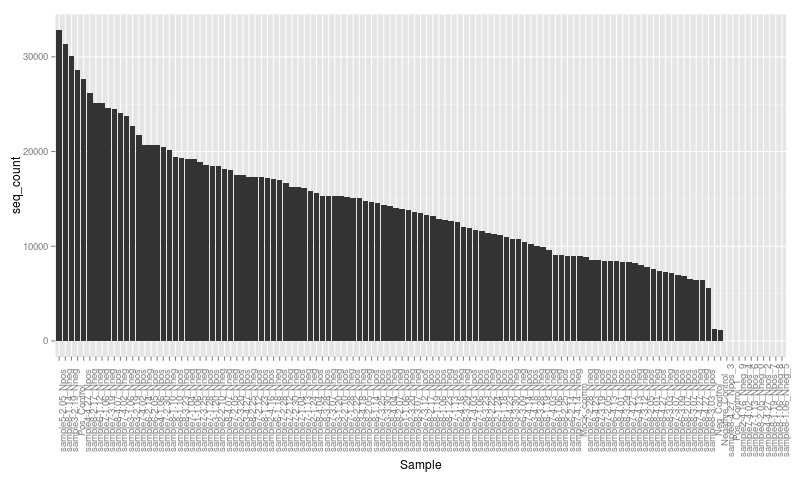

In [30]:
%%R -i df_seq_cnt -w 800
# plotting all

df_seq_cnt$seq_count = as.numeric(df_seq_cnt$seq_count)

df_seq_cnt = df_seq_cnt %>% 
    mutate(rank = min_rank(seq_count)) %>%
    arrange(desc(rank))

df_seq_cnt$Sample = factor(df_seq_cnt$Sample, levels=df_seq_cnt$Sample)

ggplot(df_seq_cnt, aes(Sample, seq_count)) +
    geom_bar(stat='identity') +
    theme(
        axis.text.x = element_text(angle=90)
    )

## Samples with a very low number of reads

In [31]:
%%R
df_seq_cnt %>% filter(seq_count < 100)

                Sample seq_count rank
1  sample8-4.27_Npos_3         1    1
2        Pos_Control_1         1    1
3  sample2-4.16_Nneg_9         1    1
4  sample7-4.02_Npos_4         1    1
5  sample7-1.13_Npos_6         1    1
6  sample8-2.05_Nneg_0         1    1
7  sample4-4.27_Npos_2         1    1
8  sample8-1.19_Npos_7         1    1
9  sample8-1.06_Nneg_8         1    1
10 sample8-1.06_Nneg_5         1    1


In [32]:
%%R
df_seq_cnt$seq_count %>% sum

[1] 1591277


In [33]:
%%R
df_seq_cnt %>% head

             Sample seq_count rank
1 sample5-2.05_Npos     32845  119
2 sample8-1.14_Nneg     31399  118
3 sample3-2.19_Nneg     30142  117
4       Pos_Control     28589  116
5 sample4-4.27_Npos     27689  115
6 sample8-2.17_Nneg     26195  114


## Summing by sample

In [52]:
%%R
# edit table

#df_seq_cnt$Treatment = gsub('_20yrOrg_', '-20yrOrg-', df_seq_cnt$Sample)
#df_seq_cnt$Treatment = gsub('_.+', '', df_seq_cnt$Treatment)
#df_seq_cnt$Rep = gsub('.+D[0-9]+R([0-9]+).+', '\\1', df_seq_cnt$Sample)
#df_seq_cnt$Rep = gsub('.+seqR', '\\1', df_seq_cnt$Rep)
#df_seq_cnt$seq_count = as.numeric(df_seq_cnt$seq_count)

NULL


In [53]:
%%R
# summing by sample

#df_seq_cnt_agg = df_seq_cnt %>%
#    group_by(Treatment) %>%
#    summarize(
#        mean_count = mean(seq_count, na.rm=TRUE),
#        stderr_count = sd(seq_count)/sqrt(length(seq_count))
#    )

NULL


In [ ]:
%%R
# plotting by treatment

#ggplot(df_seq_cnt_agg, aes(Treatment, mean_count)) +
 #   geom_bar(stat='identity', fill='red', alpha=0.7) +
  #  geom_linerange(aes(ymin=mean_count-stderr_count, ymax=mean_count+stderr_count)) +
   # labs(y='Mean sequence count') +
    #theme(
     #   text = element_text(size=16),
      #  axis.text.x = element_text(angle=90, hjust=1),
       # axis.title.x = element_blank()
    #)